In [1]:
%cd ..

/hdd/aouadt/these/projets/3d_segm


In [2]:
# %% Morp Registration
from importlib import reload
import os

import nibabel as nib
import cv2
from time import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import skimage.morphology as morp
import skimage.measure as meas
from scipy.ndimage import rotate
from scipy.spatial import procrustes
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import general.utils as u
import general.array_morphology as am

def reload_modules():
    for modl in [u, am]:
        reload(modl)

reload_modules()

In [3]:
# %%
def plot_arrays(*ars):
    plt.close()
    fig, axs = plt.subplots(1, len(ars))
    for i in range(len(axs)):
        axs[i].imshow(ars[i], interpolation='nearest')
    fig.show()


def show_point_cloud(*ars, shape=(100, 100)):
    toshows = []

    for ar in ars:
        toshow = np.zeros(shape)
        toshow[ar[:, 0].round().astype(int), ar[:, 1].round().astype(int)] = 1
        toshows.append(toshow)

    plot_arrays(*toshows)


def sort_points(X):

    x, y = X[:, 0], X[:, 1]
    x0 = np.mean(x)
    y0 = np.mean(y)

    r = np.sqrt((x-x0)**2 + (y-y0)**2)

    angles = np.where((y-y0) > 0, np.arccos((x-x0)/r), 2*np.pi-np.arccos((x-x0)/r))

    mask = np.argsort(angles)

    x_sorted = x[mask]
    y_sorted = y[mask]

    return np.stack((x_sorted, y_sorted)).T


In [6]:
# %%
plt.close()
ar1 = np.zeros((100, 100))
ar1[40: 60, 40:60] = 1
ar1 = ar1.astype(int)

ar2 = np.zeros((100, 100))
ar2[44: 69, 44: 69] = 1
ar2 = rotate(ar2, 30) > .4
ar2 = ar2[30: 130, 30: 130]
# ar2[30:70, 30:70] = 1

print(ar1.sum(), ar2.sum())

selem = morp.disk(1)
bord1 = am.array_dilation(ar1, selem) - ar1
bord2 = am.array_dilation(ar2, selem) - ar2

print(bord1.sum(), bord2.sum())

400 632
80 88


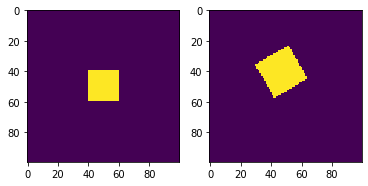

In [7]:
# %%
plot_arrays(ar1, ar2)


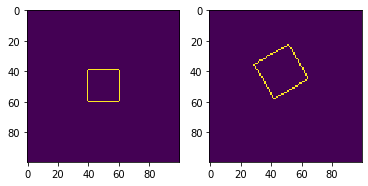

In [8]:
# %%
plot_arrays(bord1, bord2)


In [9]:
# %%

bord1r = cv2.resize(bord1, (102, 102), interpolation=cv2.INTER_NEAREST)
bord2r = cv2.resize(bord2, (98, 98), interpolation=cv2.INTER_NEAREST)
print(bord1r.sum(), bord2r.sum())

84 84


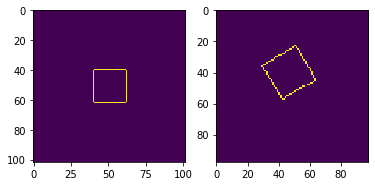

In [10]:
# %%
plot_arrays(bord1r, bord2r)

80 88
7 7


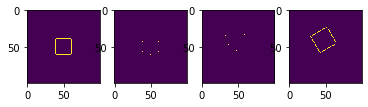

In [11]:
# %%
x1s, y1s = np.where(bord1 != 0)
x2s, y2s = np.where(bord2 != 0)

X1 = sort_points(np.stack((x1s, y1s)).T)
X2 = sort_points(np.stack((x2s, y2s)).T)


print(len(x1s), len(x2s))

npoints = 7

X1s = X1[np.linspace(0, len(x1s)-1, npoints).round().astype(int)]
X2s = X2[np.linspace(0, len(x2s)-1, npoints).round().astype(int)]
print(len(X1s), len(X2s))

show_point_cloud(X1, X1s, X2s, X2)

In [19]:
# %%

def get_transform_procrustes(ar1, ar2):
    """
    Solves min_T || ar1 @ T - ar2||
    """
    return np.linalg.inv(ar1.T @ ar1) @ ar1.T @ ar2

def iteration_procrustes(ar1, ar2):
    T = get_transform_procrustes(ar1, ar2)
    err = np.linalg.norm(ar1 @ T - ar2)
    return T, err

def solve_procrustes(ar1, ar2):
    best_err = np.infty
    best_T = None

    print("Computing permutations...")
    all_permuts = u.get_arrangements(len(ar1))
    print(f"Done. {len(all_permuts)} permutations being tried.")
    all_errs = []
    all_Ts = []
    for perm in all_permuts:
        ar2p = ar2[perm]
        T, err = iteration_procrustes(ar1, ar2p)
        all_errs.append(err)
        all_Ts.append(T)
        if err < best_err:
            best_T, best_err = T, err

    return best_T, best_err, all_errs, all_Ts



def get_rot_matrix(angle):
    return np.array([
        [np.cos(angle), - np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])

Computing permutations...
Done. 5040 permutations being tried.
0.1194906234741211


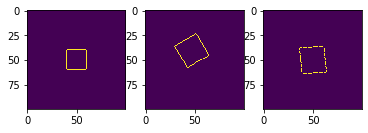

In [20]:
# %%
reload_modules()
plt.close()

t1 = time()
T, err, all_errs, all_Ts = solve_procrustes(X1s - X1s.mean(0), X2s - X2s.mean(0))
print(time() - t1)
# T = get_rot_matrix(np.pi/6).T

show_point_cloud(X1, X2, ((X1 - X1.mean(0))@T) + 50)


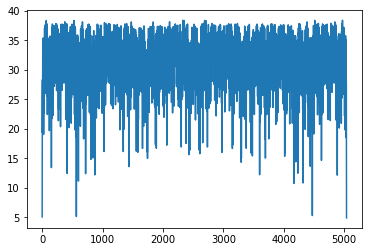

In [21]:
# %%
plt.plot(all_errs)
plt.show()

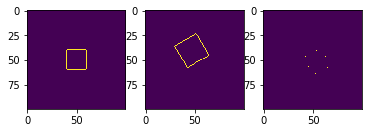

In [25]:
# %%
# proc1, proc2, err = procrustes(X1 - X1.mean(0), X2 - X2.mean(0))
proc1, proc2, err = procrustes(X1s, X2s)

shape = 100
proc1 = (proc1 - proc1.min()) / (proc1.max() - proc1.min()) * 25 + 40
proc2 = (proc2 - proc2.min()) / (proc2.max() - proc2.min()) * 25 + 40

show_point_cloud(X1, X2, proc2)


In [ ]:
# %%

path_segm = os.path.abspath("/hdd/datasets/CT-ORG/raw/labels_and_README/labels-4.nii.gz")

seg3n = nib.load(path_segm)

seg3 = np.round(seg3n.get_fdata()) == 2


In [ ]:
# %%
reload_modules()
t1 = time()
reg3 = (u.get_most_important_regions(seg3) > 0).astype(int)
print(time() - t1)

In [ ]:
# %%

t1 = time()
verts, faces, normals, values = meas.marching_cubes(reg3)
print(time() - t1)
print(len(verts))


In [ ]:
# %%
plt.close()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(*verts.T)
fig.show()

In [ ]:
# %%
u.save_as_nii(
    "segmentations/CT_ORG/labels-4-opened.nii.gz",
    reg3,
    seg3n.affine,
    dtype=np.uint8
)
